In [2]:
# === NLP & Text Processing ===
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# === Core Libraries ===
import os
import sys
import math
import re
import warnings
from pathlib import Path
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

# === Statistics ===
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# === Machine Learning ===
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [3]:
df = pd.read_csv("Datasets/train_dataset.csv", encoding="latin1")
df.drop(columns=["selected_text"], inplace=True)
df.drop(columns=["Population -2020"], inplace=True)
df.drop(columns=["Land Area (Km²)"], inplace=True)
df.drop(columns=["Density (P/Km²)"], inplace=True)
df.to_csv("Datasets/clean_train.csv", index=False, encoding="latin1")
print(df.shape)
df.head()
df["Country"].nunique()
print(df['sentiment'].value_counts())
print(df["sentiment"].value_counts(normalize=True) * 100)

(27481, 6)
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64
sentiment
neutral     40.457043
positive    31.228849
negative    28.314108
Name: proportion, dtype: float64


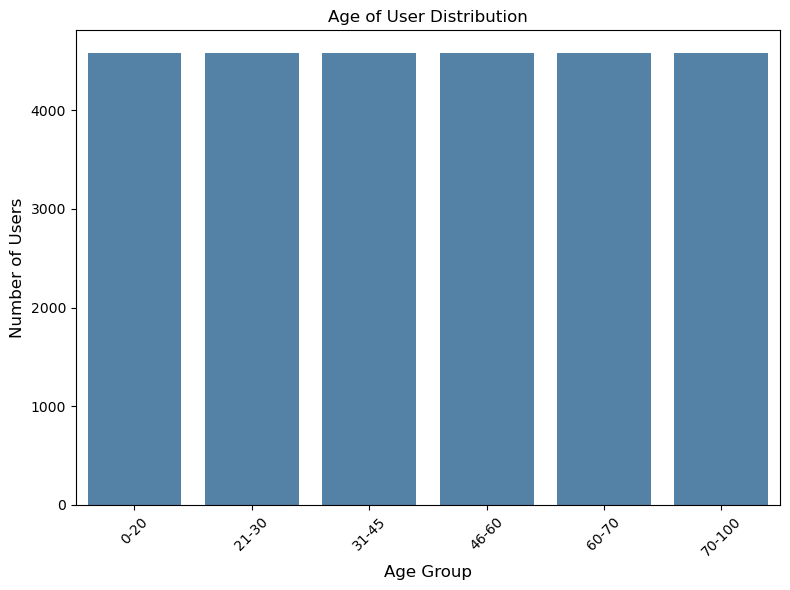

In [6]:
df = pd.read_csv("Datasets/train_dataset.csv", encoding="latin1")

df["Age of User"] = df["Age of User"].astype(str).str.strip()

age_counts = df["Age of User"].value_counts().sort_index()

plt.figure(figsize=(8,6))
sns.barplot(x=age_counts.index, y=age_counts.values, color="steelblue")

plt.title("Age of User Distribution", fontsize=12)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ct = pd.crosstab(df["Time of Tweet"], df["sentiment"])
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Time of Tweet vs Sentiment")
plt.ylabel("Time of Tweet")
plt.xlabel("Sentiment")
plt.show()

ct = pd.crosstab(df["Age of User"], df["sentiment"])
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Reds")
plt.title("Age of User vs Sentiment")
plt.ylabel("Age of User")
plt.xlabel("Sentiment")
plt.show()

Mevcut sınıflar: ['neg', 'neu', 'pos']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



=== Classification Report ===
              precision    recall  f1-score   support

         neg      0.652     0.669     0.660      1556
         neu      0.630     0.623     0.626      2223
         pos      0.731     0.725     0.728      1717

    accuracy                          0.668      5496
   macro avg      0.671     0.672     0.671      5496
weighted avg      0.668     0.668     0.668      5496

Overall Accuracy: 0.6675764192139738


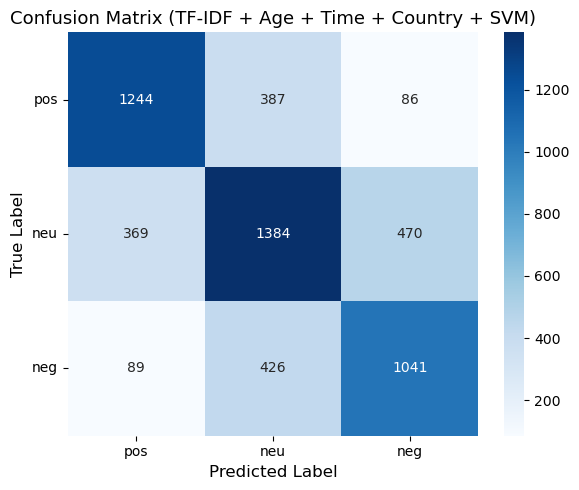

In [24]:
# Features like Time of Tweet, Age of user, Country are used.!!

def norm_label(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    mapping = {
        "pos":"pos","positive":"pos","olumlu":"pos","1":"pos",
        "neg":"neg","negative":"neg","olumsuz":"neg","-1":"neg",
        "neu":"neu","neutral":"neu","nötr":"neu","notr":"neu","0":"neu"
    }
    return mapping.get(s, s)

df["sentiment"] = df["sentiment"].apply(norm_label)
df = df.dropna(subset=["text","sentiment"]).copy()
present = sorted(df["sentiment"].unique())
print("Mevcut sınıflar:", present)

cat_feats = ["Age of User","Time of Tweet","Country"]
X = df[["text"] + cat_feats]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

text_vec = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)
cat_enc  = OneHotEncoder(handle_unknown="ignore")

preproc = ColumnTransformer(transformers=[
    ("text", text_vec, "text"),
    ("cat",  cat_enc,  cat_feats)
])

clf = Pipeline([
    ("prep", preproc),
    ("svm", LinearSVC(C=1.0, class_weight="balanced", random_state=42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# === Classification Report ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, labels=present, digits=3))
print("Overall Accuracy:", accuracy_score(y_test, y_pred))

label_order = ["neg", "neu", "pos"]
cm = confusion_matrix(y_test, y_pred, labels=label_order)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=label_order, yticklabels=label_order, ax=ax
)

ax.set_title("Confusion Matrix (TF-IDF + Age + Time + Country + SVM)", fontsize=13)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

ax.invert_yaxis()

ax.invert_xaxis()

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Mevcut sınıflar: ['neg', 'neu', 'pos']

=== MultinomialNB Classification Report ===
              precision    recall  f1-score   support

         neg      0.652     0.669     0.660      1556
         neu      0.630     0.623     0.626      2223
         pos      0.731     0.725     0.728      1717

    accuracy                          0.668      5496
   macro avg      0.671     0.672     0.671      5496
weighted avg      0.668     0.668     0.668      5496

Overall Accuracy: 0.668


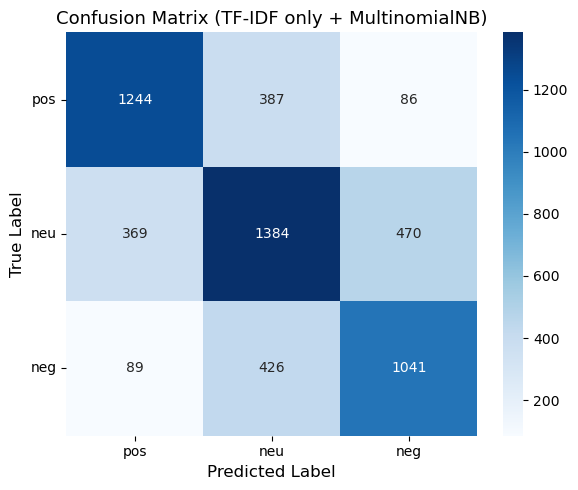

In [30]:
# Features are not used.!!EEUEUEUEUEEUEUAGOUHEUGJVBAJGOVABEGOLGABVOAJ
#;SDGKMSK;GKSNGMSKGNSGNSGKPSNGP;

def norm_label(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    mapping = {
        "pos":"pos","positive":"pos","olumlu":"pos","1":"pos",
        "neg":"neg","negative":"neg","olumsuz":"neg","-1":"neg",
        "neu":"neu","neutral":"neu","nötr":"neu","notr":"neu","0":"neu"
    }
    return mapping.get(s, s)

df["sentiment"] = df["sentiment"].apply(norm_label)
df = df.dropna(subset=["text","sentiment"]).copy()
present = sorted(df["sentiment"].unique())
print("Mevcut sınıflar:", present)

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)

nb_clf = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)),
    ("nb",    MultinomialNB(alpha=1.0))  # alpha: Laplace/Lidstone smoothing
])

# === Classification Report ===
print("\n=== MultinomialNB Classification Report ===")
print(classification_report(y_test, y_pred, labels=["neg", "neu", "pos"], digits=3))
print("Overall Accuracy:", round(accuracy_score(y_test, y_pred), 3))

label_order = ["neg", "neu", "pos"]

cm = confusion_matrix(y_test, y_pred, labels=label_order)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=label_order, yticklabels=label_order,
    ax=ax
)

ax.set_title("Confusion Matrix (TF-IDF only + MultinomialNB)", fontsize=13)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

ax.invert_xaxis()

ax.invert_yaxis()

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
## VADER Analyzer

sia = SentimentIntensityAnalyzer()

df["sentiment_scores"] = df["text"].apply(lambda x: sia.polarity_scores(str(x)))

def vader_label(score_dict):
    c = score_dict["compound"]
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_found"] = df["sentiment_scores"].apply(vader_label)

df.to_csv("Datasets/sentiment_lexicon-based.csv", index=False, encoding="latin1")

true_labels = df["sentiment"].map(str.lower).replace({
    "pos": "positive", "neg": "negative", "neu": "neutral"
})
pred_labels = df["sentiment_found"]

label_order = ["negative", "neutral", "positive"]

print("\n=== VADER Classification Report ===")
print(classification_report(true_labels, pred_labels, labels=label_order, digits=3))
print("Overall Accuracy:", round(accuracy_score(true_labels, pred_labels), 3))

true_labels = true_labels.str.lower().replace({
    "positive": "pos",
    "negative": "neg",
    "neutral": "neu"
})

pred_labels = pred_labels.str.lower().replace({
    "positive": "pos",
    "negative": "neg",
    "neutral": "neu"
})

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_order = ["neg", "neu", "pos"]  # orijinal sıra
cm = confusion_matrix(true_labels, pred_labels, labels=label_order)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=label_order, yticklabels=label_order,
    ax=ax
)

ax.set_title("Confusion Matrix (VADER Lexicon-Based)", fontsize=13)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

ax.invert_xaxis()

ax.invert_yaxis()

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()